Written by Drew, based on cnn.ipynb, precursor to cnn_classification.ipynb

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


from PIL import Image
import matplotlib.pyplot as plt

from collections import Counter


# Load Dataset

In [2]:
CSV_FILE_NAME = './data/my_file.csv'
# CSV_FILE_NAME = './data/my_file_400.csv'
arr = pd.read_csv(CSV_FILE_NAME, header=None)

In [3]:
X, y_class, y_reg = arr.iloc[:, :-5].values, arr.iloc[:, -5:-4].values, arr.iloc[:, -4:].values
print(y_reg)
X = X.reshape(-1, 200, 200, 1)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)


[[0.523969 0.458252 0.474916 0.897087]
 [0.524526 0.378641 0.299889 0.625243]
 [0.569119 0.506796 0.397993 0.88932 ]
 ...
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]]


# Model

In [8]:
model = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    # layers.Input(shape=(400, 400, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    # layers.Conv2D(32, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    # layers.Conv2D(64, 3, kernel_regularizer=l2(0.0001), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    # layers.Dense(4, activation=None)
    layers.Dense(4, activation='sigmoid')
])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)


model.compile(optimizer=Adam(0.001),
              loss="mse",
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,456,324 (36.07 MB)

 Trainable params: 9,456,324 (36.07 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train_reg, epochs=50, validation_data=(X_test, y_test_reg))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 588ms/step - accuracy: 0.4578 - loss: 0.0782 - val_accuracy: 0.7538 - val_loss: 0.0289
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 582ms/step - accuracy: 0.7337 - loss: 0.0249 - val_accuracy: 0.7385 - val_loss: 0.0241
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.8035 - loss: 0.0164 - val_accuracy: 0.7538 - val_loss: 0.0238
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 614ms/step - accuracy: 0.8373 - loss: 0.0105 - val_accuracy: 0.8077 - val_loss: 0.0224
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 617ms/step - accuracy: 0.8333 - loss: 0.0081 - val_accuracy: 0.8000 - val_loss: 0.0210
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 608ms/step - accuracy: 0.8369 - loss: 0.0058 - val_accuracy: 0.7769 - val_loss: 0.0209
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step - accuracy: 0.8437 - loss: 0.0050 - val_accuracy: 0.7769 - val_loss: 0.0208
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.8612 - loss: 0.0046 - val_accur

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

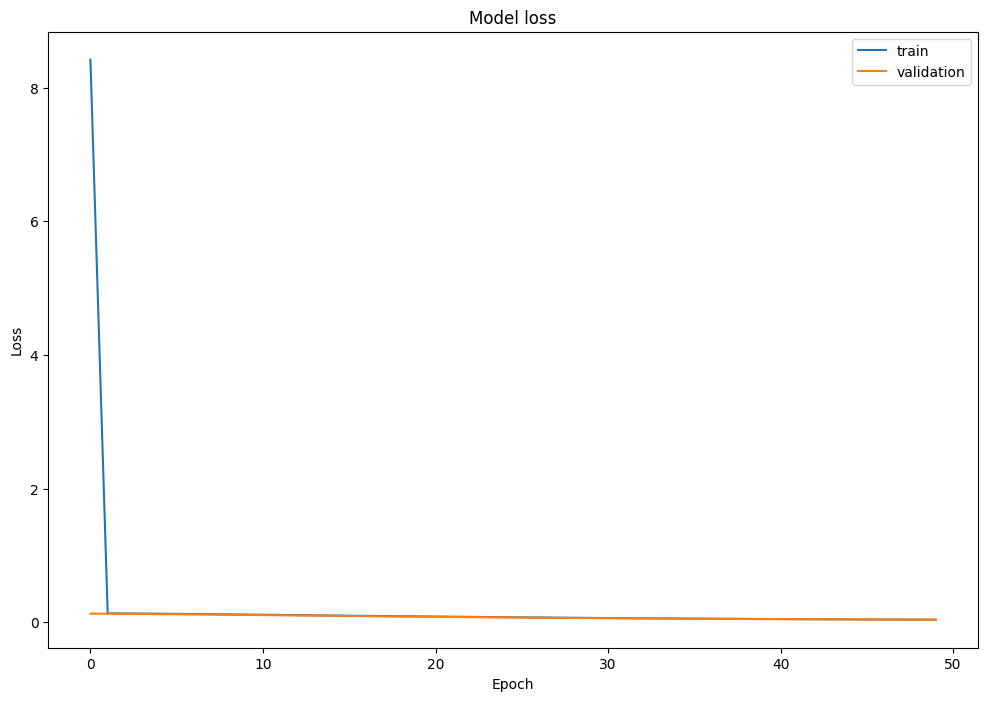

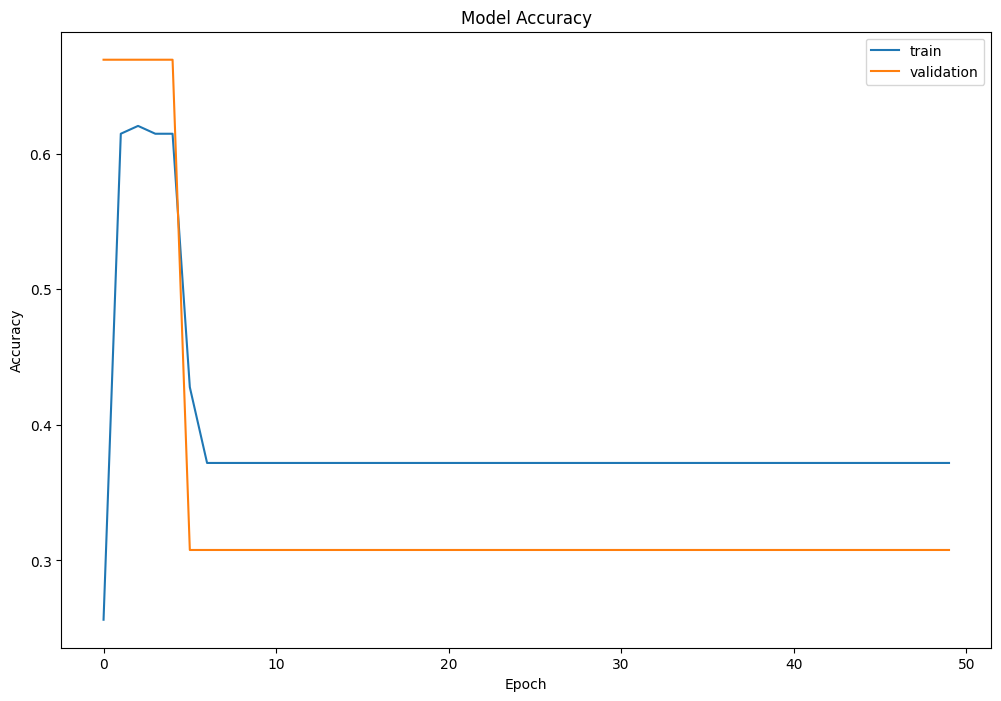

In [6]:
# Convert model history dictionary to DataFrame
df_loss_acc = pd.DataFrame(model.history.history)

# Select loss columns and rename
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

# Select accuracy columns and rename
df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plot model loss
df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot model accuracy
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')


In [7]:
result = model.evaluate(X_test, y_test_reg)
print("Result:", result)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2944 - loss: 0.0400 
Result: [0.04017454758286476, 0.3076923191547394]
